# COV19 Open Data in Mexico - EDA and Prediction
**資工三1 楊啟弘 1410832005**

## **Contents**
1. [Introduce](#1-introduce)
2. [Import](#2-Import)
3. [Data Loading and Preparation](#3-Data-Loading-and-Preparation)
4. [Exploratory Data Analysis](#4-Exploratory-Data-Analysis)
5. [Data Pre-Processing](#5-Data-Pre--Processing)
6. [Modeling](#6-Modeling)
7. [Feedback](#7-Feedback)
8. [Reference](#8-Reference)

## 1.  Introduce
資料集選用了在Kaggle上的墨西哥新冠肺炎患者資料集
> https://www.kaggle.com/datasets/omarlarasa/cov19-open-data-mexico

墨西哥是 COV19 死亡人數最多的前五個國家。醫院裡每天都有很多病人死去。
該數據集由墨西哥衛生局收集而來，包含收集數據（2021年4月）前的有關COV19患者的所有登記名冊。
### - 內容
裡面是關於病人的相關數據，包含在哪裡住院、居住在哪裡，以及他們的年齡和死亡日期。還有許多有趣的資訊，除了COVID19的資訊之外，還可以得知患者的額外症狀，例如糖尿病、肥胖、高血壓等。最後還有其他重要的特徵像是患者是否有抽煙、是否被診斷出肺炎、或是是否被插管等。
### - 動機
1. 資料數量龐大
2. 想透過資料探勘來瞭解COV19對其他國家的影響以及台灣和其他國家的患者情況有什麼不同
## 2.   Import

In [2]:
import pandas as pd
import numpy as np
import os

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.graph_objects as go
from IPython.display import display

## 3.   Data Loading and Preparation

### Exploring Data

In [3]:
train = pd.read_csv("/Users/young900221/Downloads/archive-2/data.csv", encoding='utf-8')

#### Column Descriptions:

* 患者基本資料：
    * ```SEXO```：性別（0：女性，1：男性）
    * ```EDAD```：年齡
    * ```EMBARAZO```：是否懷孕
    * ```INDIGENA```：是否為原住民
    * ```TABAQUISMO```：是否有吸煙習慣
* 患者COV19病情狀況：
    * ```ORIGEN```：衛生單位
    * ```TIPO_PACIENTE```：門診 or 住院（0：住院，1：門診）
    * ```FECHA_DEF```：患者死亡日期
    * ```INTUBADO```：是否插管
    * ```NEUMONIA```：是否被診斷出患有肺炎
    * ```UCI```：是否需要進重症監護室
    * ```OTRO_CASO```：是否有接觸史
* 患者慢性病資料：
    * ```DIABETES```：是否有糖尿病
    * ```EPOC```：是否有COPD(慢性呼吸道疾病)
    * ```ASMA```：是否有哮喘
    * ```INMUSUPR```：是否有免疫抑制
    * ```HIPERTENSION```：是否有高血壓
    * ```CARDIOVASCULAR```：是否有心血管疾病
    * ```OBESIDAD```：是否有肥胖
    * ```RENAL_CRONICA```：是否有慢性腎功能衰竭





Remove unnecessary column:

In [4]:
drop_col = ['FECHA_ACTUALIZACION','ID_REGISTRO','SECTOR','ENTIDAD_UM',
            'ENTIDAD_NAC','ENTIDAD_RES','NACIONALIDAD','HABLA_LENGUA_INDIG',
            'OTRA_COM','TOMA_MUESTRA_LAB','RESULTADO_LAB','CLASIFICACION_FINAL',
            'MIGRANTE','PAIS_NACIONALIDAD','PAIS_ORIGEN','RESULTADO_ANTIGENO',
            'TOMA_MUESTRA_ANTIGENO','FECHA_INGRESO','FECHA_SINTOMAS','MUNICIPIO_RES']
train.drop( drop_col, axis=1, inplace=True )

Below are the first 5 rows of dataset:

In [5]:
train.head()

,ORIGEN,SEXO,TIPO_PACIENTE,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,EMBARAZO,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,UCI
0,1,2,1,9999-99-99,97,2,41,97,99,2,2,2,2,2,2,2,2,2,2,97
1,1,1,2,2020-07-21,1,1,66,2,2,1,2,2,2,1,2,1,2,2,1,1
2,1,2,1,9999-99-99,97,2,29,97,2,2,2,2,2,2,2,98,2,2,2,97
3,1,1,1,9999-99-99,97,2,40,98,99,2,2,2,2,2,2,2,2,2,1,97
4,1,2,1,9999-99-99,97,2,34,97,2,2,1,1,2,2,2,2,2,2,2,97


Below are the shape of the dataset:

In [6]:
train.shape

(6659184, 20)

Below are the type of the column:

In [7]:
def Col_Types( Data ):
    Column_Types = Data.dtypes.to_frame().reset_index()
    Column_Types.columns = ['ColumnName','Type']
    Column_Types.sort_values( by='Type', inplace=True ) 
    return Column_Types

display( Col_Types(train) )

,ColumnName,Type
0,ORIGEN,int64
17,TABAQUISMO,int64
16,RENAL_CRONICA,int64
15,OBESIDAD,int64
14,CARDIOVASCULAR,int64
13,HIPERTENSION,int64
12,INMUSUPR,int64
11,ASMA,int64
10,EPOC,int64
9,DIABETES,int64


Checking the NULL values

In [8]:
train.isnull().sum()

ORIGEN            0
SEXO              0
TIPO_PACIENTE     0
FECHA_DEF         0
INTUBADO          0
NEUMONIA          0
EDAD              0
EMBARAZO          0
INDIGENA          0
DIABETES          0
EPOC              0
ASMA              0
INMUSUPR          0
HIPERTENSION      0
CARDIOVASCULAR    0
OBESIDAD          0
RENAL_CRONICA     0
TABAQUISMO        0
OTRO_CASO         0
UCI               0
dtype: int64

Converting the continous values of the age into the categorical Data:

|    AGE   |  Status  |
|:--------:|:--------:|
|  Below 5 |     0    |
|    6~17  |     6    |
|   18~44  |     18   |
|   45~64  |     45   |
|  65~120  |     65   |

In [9]:
train['EDAD'] = pd.cut(x=train['EDAD'], bins=[0,5,17,44,64,120],
                     labels=[0,6,18,45,65])

在資料集的***是否***特徵（例如：是否有懷孕？是否有糖尿病）中，總共有五種回答，分別是：
1. ```1```：是
2. ```2```：否
3. ```97```：不適用
4. ```98```：被忽略
5. ```99```：未指定

爲了保持資料集的乾淨，因此要刪除```被忽略```、```未指定```的資料，並把```不適用```的值改成```否```。最終再把```是```跟```否```的 value 轉換成 ```1``` 跟 ```0``` 。

Cleaning the "null" values

In [10]:
for column in train.columns:
    
    train = train.drop(train[train[column]==98].index, axis=0)
    train = train.drop(train[train[column]==99].index, axis=0)

Changing the values

In [11]:
train['INTUBADO'] = train['INTUBADO'].replace({97: 0})
train['UCI'] = train['UCI'].replace({97: 0})
train['EMBARAZO'] = train['EMBARAZO'].replace({97: 0})


for column in train.columns:
    train[column] = train[column].replace({2: 0})

Identifying the unique count in each feature

In [12]:
dict = {}
for i in list(train.columns):
    dict[i] = train[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
ORIGEN,2
SEXO,2
TIPO_PACIENTE,2
FECHA_DEF,470
INTUBADO,2
NEUMONIA,2
EDAD,5
EMBARAZO,2
INDIGENA,2
DIABETES,2


Checking the shape of the dataset:

In [13]:
train.shape

(5959146, 20)

In [14]:
train.head()

,ORIGEN,SEXO,TIPO_PACIENTE,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,EMBARAZO,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,UCI
1,1,1,0,2020-07-21,1,1,65,0,0,1,0,0,0,1,0,1,0,0,1,1
4,1,0,1,9999-99-99,0,0,18,0,0,0,1,1,0,0,0,0,0,0,0,0
6,1,1,1,9999-99-99,0,0,45,0,0,0,0,0,0,0,0,1,0,0,0,0
7,1,1,1,9999-99-99,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,1,9999-99-99,0,0,45,0,0,1,0,0,0,0,0,0,0,0,0,0


Converting date of death to dead or not

In [15]:
target = []

for value in train['FECHA_DEF'].values:
    if value == '9999-99-99': 
        target.append(0)
    else: 
        target.append(1)
train['DEATH'] = target

del train['FECHA_DEF']

### 📌  資料集總結：
* 總共有**21**個特徵欄位和**5933998**筆資料。
* ```DEATH```是我們需要預測的特徵欄位。

## 4.   Exploratory Data Analysis

### 死亡比例

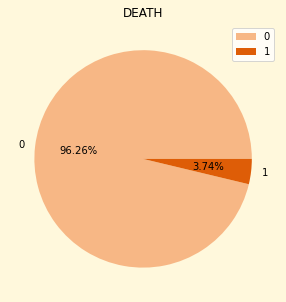

In [16]:
plt.figure( figsize=(10,5), facecolor="#FFF8DC" )
train['DEATH'].value_counts().plot( kind='pie', colors=['#f7b785','#de5d07'], autopct='%1.2f%%')
plt.title( 'DEATH' ) 
plt.legend(loc = "best")
plt.ylabel( '' )
plt.show()

### 特徵分佈

#### 長條圖

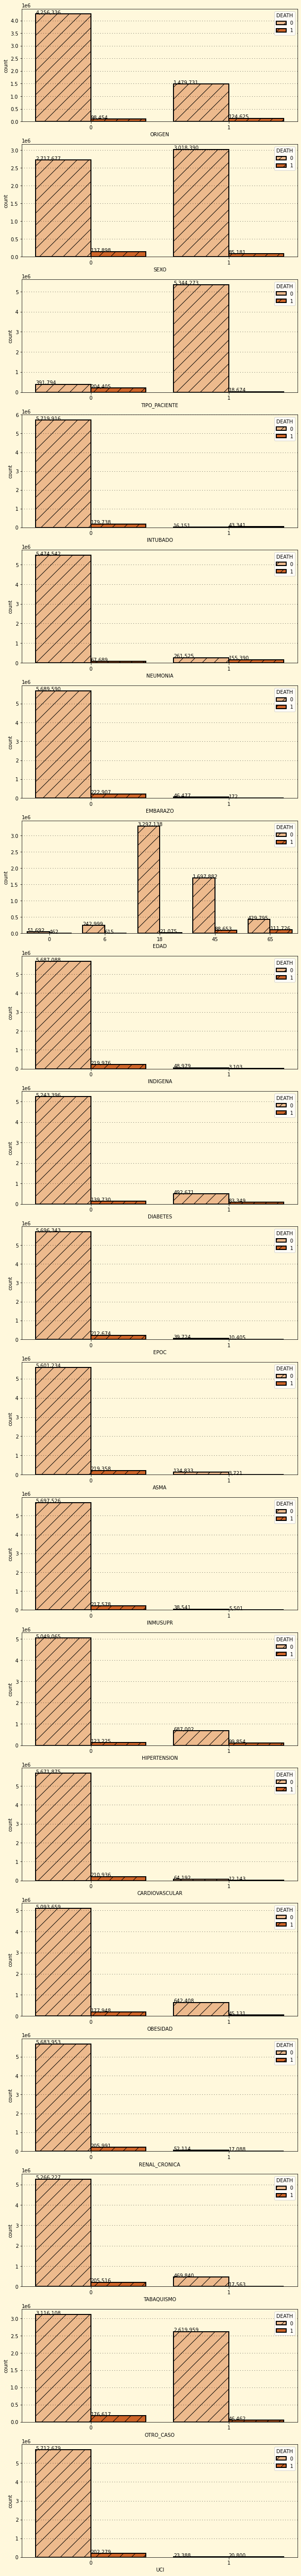

In [17]:
selected_cols = [   "ORIGEN","SEXO","TIPO_PACIENTE","INTUBADO","NEUMONIA","EMBARAZO",'EDAD',
                    "INDIGENA","DIABETES","EPOC","ASMA","INMUSUPR","HIPERTENSION","CARDIOVASCULAR",
                    "OBESIDAD","RENAL_CRONICA","TABAQUISMO","OTRO_CASO","UCI"]

plt.figure( figsize=(10,len(selected_cols)*5), facecolor="#FFF8DC")
gs = gridspec.GridSpec(len(selected_cols),1)    
for i, col in enumerate( train[selected_cols] ) :        
    ax = plt.subplot( gs[i] )
    ax.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
    sns.countplot(ax=ax, data=train, x=train[col], palette = 'Oranges', hue='DEATH',edgecolor='black',**{'hatch':'/','linewidth':2})
    ax.set_facecolor("#FFF8DC")
    for p in ax.patches:
        ax.annotate( '{:,}'.format(p.get_height()), (p.get_x(), p.get_height()+1.5) )
plt.show()

#### 統計圖

In [18]:
for col in selected_cols:
    l = ['DEATH']
    l.append(col) 
    Death_Rate = train[l].groupby(by=col).mean().round(4).reset_index()
    Death_Rate.columns = [col,'Death Rate(%)']
    Death_Rate['Death Rate(%)'] = Death_Rate['Death Rate(%)'].map( lambda x:x*100 )
    display( Death_Rate )

,ORIGEN,Death Rate(%)
0,0,2.26
1,1,7.77


,SEXO,Death Rate(%)
0,0,4.83
1,1,2.74


,TIPO_PACIENTE,Death Rate(%)
0,0,34.28
1,1,0.35


,INTUBADO,Death Rate(%)
0,0,3.05
1,1,72.85


,NEUMONIA,Death Rate(%)
0,0,1.22
1,1,37.27


,EMBARAZO,Death Rate(%)
0,0,3.77
1,1,0.37


,EDAD,Death Rate(%)
0,0,0.89
1,6,0.25
2,18,0.64
3,45,4.96
4,65,20.63


,INDIGENA,Death Rate(%)
0,0,3.72
1,1,5.96


,DIABETES,Death Rate(%)
0,0,2.60
1,1,14.47


,EPOC,Death Rate(%)
0,0,3.60
1,1,20.76


,ASMA,Death Rate(%)
0,0,3.77
1,1,2.69


,INMUSUPR,Death Rate(%)
0,0,3.68
1,1,12.49


,HIPERTENSION,Death Rate(%)
0,0,2.38
1,1,12.69


,CARDIOVASCULAR,Death Rate(%)
0,0,3.59
1,1,15.91


,OBESIDAD,Death Rate(%)
0,0,3.38
1,1,6.56


,RENAL_CRONICA,Death Rate(%)
0,0,3.50
1,1,24.69


,TABAQUISMO,Death Rate(%)
0,0,3.76
1,1,3.60


,OTRO_CASO,Death Rate(%)
0,0,5.36
1,1,1.74


,UCI,Death Rate(%)
0,0,3.42
1,1,47.07


#### 熱地圖

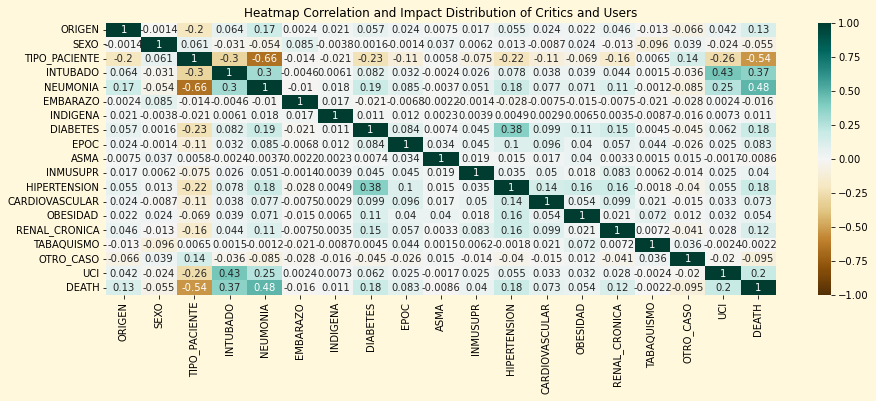

In [19]:
plt.figure(figsize=(15,5), facecolor="#FFF8DC")
plt.title('Heatmap Correlation and Impact Distribution of Critics and Users')
sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

plt.show()

### 📌  透過上述的長條圖、統計表、以及熱地圖，可得到下列的觀察：

### 長條圖與統計圖
* 女性的死亡率比男性高
* 住院的死亡率比門診高
* 如果墨西哥人插管了，他可能有34.25％的機率會死掉
* 墨西哥原住民死亡率比較高
* 糖尿病、COPD、哮喘的患者如果確診了，死亡率會高上10%左右
* 墨西哥胖子如果確診了，死亡率會高上3%左右
* 如果是慢性勝功能衰竭的患者確診，死亡率會比一般人高20%左右
* 墨西哥人抽菸跟沒抽菸，死亡機率幾乎一樣
* 沒有接觸史的患者的死亡率比有接觸史的患者高3%
* 住進UCI的墨西哥人的死亡率會比一般患者高上45%

### 熱地圖
* 有懷孕的一定是女性
* 插管的墨西哥人一定會住進醫院的UCI
* 患上肺炎的墨西哥人比較容易住院並且比較容易插管

### 小結

雖然大部分觀察到的相關性或者比較性都是早已了解的，像是大家都知道有慢性病的確診患者比較容易死亡或住進UCI的患者已經很嚴重了，但能夠透過自己來進行資料分析並且看到準確的數字資料，感覺還是大不相同。除此之外另外一個讓我比較訝異的是沒有接觸史的患者死亡率比較高，這可能是一般人不知道的，我猜測可能有接觸史的患者身上擁有比較多抗體所以比起來稍微比較不容易死亡吧！

## 5.   Data Pre-Processing

### Continous and Categorical Data

In [20]:
cat_cols = [    "ORIGEN","SEXO","TIPO_PACIENTE","INTUBADO","NEUMONIA","EMBARAZO","INDIGENA","DIABETES","EPOC","ASMA",
                "INMUSUPR","HIPERTENSION","CARDIOVASCULAR","OBESIDAD","RENAL_CRONICA","TABAQUISMO","OTRO_CASO","UCI"]
con_cols = ["EDAD"]
target_col = ["DEATH"]
print("The categorial cols are : ", cat_cols)
print("The continuous cols are : ", con_cols)
print("The target variable is :  ", target_col)

The categorial cols are :  ['ORIGEN', 'SEXO', 'TIPO_PACIENTE', 'INTUBADO', 'NEUMONIA', 'EMBARAZO', 'INDIGENA', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'UCI']
The continuous cols are :  ['EDAD']
The target variable is :   ['DEATH']


Encoding Categorical Features

In [21]:
label_encoder = preprocessing.LabelEncoder()

label_cols = [  "ORIGEN","SEXO","TIPO_PACIENTE","INTUBADO","NEUMONIA","EMBARAZO","EDAD",
                "INDIGENA","DIABETES","EPOC","ASMA","INMUSUPR","HIPERTENSION","CARDIOVASCULAR",
                "OBESIDAD","RENAL_CRONICA","TABAQUISMO","OTRO_CASO","UCI","DEATH"]
for col in label_cols:
    train[col]= label_encoder.fit_transform(train[col])

OneHot Encoding

In [22]:
df= pd.get_dummies(train)

x=df.drop('DEATH', axis=1)
y=df['DEATH']

## 6.   Modeling

#### Splitting the train set 

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 0)
print( f'Shape of X_train = {x_train.shape}' )
print( f'Shape of y_train = {y_train.shape}' )
print( f'Shape of X_test = {x_test.shape}' )

Shape of X_train = (4767316, 19)
Shape of y_train = (4767316,)
Shape of X_test = (1191830, 19)


#### Feature Scaling

In [24]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

#### Logistic Regression


base model version and resampling version

In [25]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_train)

#SMOTE
lr_smote = make_pipeline(SMOTE(random_state=42), LogisticRegression())
lr_smote.fit(x_train, y_train)
y_pred = lr_smote.predict(x_train)


#### Random Forest

In [26]:
rd_clf = RandomForestClassifier()
rd_clf.fit(x_train, y_train)
rd_clf_acc = accuracy_score(y_test, rd_clf.predict(x_test))

print(f"Classification Report : \n {classification_report(y_test, rd_clf.predict(x_test))}")

Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98   1147521
           1       0.62      0.37      0.47     44309

    accuracy                           0.97   1191830
   macro avg       0.80      0.68      0.73   1191830
weighted avg       0.96      0.97      0.96   1191830



#### Decision Tree

In [27]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(x_train, y_train)
y_pred = dt_clf.predict(x_test)

#### SGDClassifier

In [28]:
sgd_clf = SGDClassifier()
sgd_clf.fit(x_train, y_train)
y_pred = sgd_clf.predict(x_test)

In [29]:
print(f"------------------------lr----------------------------- \n Classification Report : \n {classification_report(y_test, lr.predict(x_test))}")
print(f"------------------------lr_SMOTE----------------------- \n Classification Report : \n {classification_report(y_test, lr_smote.predict(x_test))}")
print(f"------------------------dt_clf------------------------- \n Classification Report : \n {classification_report(y_test, dt_clf.predict(x_test))}")
print(f"------------------------sgd_clf------------------------ \n Classification Report : \n {classification_report(y_test, sgd_clf.predict(x_test))}")
print(f"------------------------rd_clf------------------------- \n Classification Report : \n {classification_report(y_test, rd_clf.predict(x_test))}")

------------------------lr----------------------------- 
 Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98   1147521
           1       0.60      0.40      0.48     44309

    accuracy                           0.97   1191830
   macro avg       0.79      0.69      0.73   1191830
weighted avg       0.96      0.97      0.96   1191830

------------------------lr_SMOTE----------------------- 
 Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97   1147521
           1       0.37      0.94      0.53     44309

    accuracy                           0.94   1191830
   macro avg       0.68      0.94      0.75   1191830
weighted avg       0.97      0.94      0.95   1191830

------------------------dt_clf------------------------- 
 Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.99      

### 小結

在這三個模型中，準確率都是97%，而過採樣版本的線性回歸模型中的準確率反而下降為93%，過採樣版本中雖然過採樣版本中的recall有明顯的提升recall的precision下降許多，但是recall的precision下降許多，上網查方法後有試過把模型的閥值往下調，但因為F1值太低而報錯，可能之後有機會的話要找其他方法試試看來解決類別不平衡的問題。

至於其他模型，在0也就是活下來的部份準確率都很高，而1也就是死亡，因為樣本過低導致準確率普遍都很低，尤其是recall的部分。這樣的情況對於預測患者是否死亡是不太好的，因為如果如果recall值太低，會提高假陽性率，以實際應用來看，會造成原本會死亡患者很容易會被預測成活者，進而被低估患者的病況。因此recall太低是勢必得解決的問題。

## 7.   Feedback

跟上次期中報告比起來，在資料探索與分析的過程中，我學習到更多畫圖表或者統計圖的方法，也能夠讓他漂亮一點，讓讀者更能快速了解到差異性。至於預測模型的部分，這次我更了解到precision, recall, 跟f1-score個別的意義，也才發現原來要依照預測何種東西，才能知道recall和precision哪個比較重要。在使用這六百萬筆的資料集中，大部分的感受就是跑每個東西都比較久，尤其是模型，這導致不能用knn這種不適合大型資料集的模型。這堂課讓我在資料科學領域上受益良多，希望有機會我會在這領域繼續學習。

## 8. Reference

* https://www.learncodewithmike.com/2021/03/pandas-data-cleaning.html
* https://yanwei-liu.medium.com/python-資料視覺化筆記-二-使用seaborn繪圖-3adb03407a9
* https://newaurora.pixnet.net/blog/post/227940020-python-使用matplotlib畫圓餅圖%28pie-chart%29
* https://www.delftstack.com/zh-tw/howto/matplotlib/use-of-pyplot.figure-matplotlib/
* https://medium.com/@PatHuang/初學python手記-3-資料前處理-label-encoding-one-hot-encoding-85c983d63f87
* https://ithelp.ithome.com.tw/articles/10216967
* https://www.twblogs.net/a/5b8ee0822b71771883486c08
